# Appling machine learning to audio analysis

## Code for Predicting 

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/3ab1d37d6edb4506aee1163539efb7da



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Functions to extract the MFCCs from every file in our dataset

In [6]:
# funçao com gerador que guarda os valores da atual posição da janela e calcula os proximos
def windows(audio, window_size):
    start = 0
    while start < len(audio):
        yield start, start + window_size # a função para aqui e returna o valor para a outra função
        start += (window_size // 10) #calcula a posição inicial do proximo segmento

In [7]:
def extract_features(file_name, window_size):
    #upload do audio
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #list de retorno
    mfccsArr = []
    
    # A função gerador é um iteravel a partir dos valores gerados durante a keyword yield
    #Percorre um audio inteiro
    for (start,end) in windows(audio, window_size):
        #Enquanto a janela nao atingir o fim do audio
        if end <= len(audio): 
            #entao define um excerto do audio
            signal = audio[start:end]
            # e calcula os coeficientes de mel
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
            mfccs_processed = np.mean(mfccs.T,axis=0)
            mfccsArr.append([mfccs_processed])
    # Retorna os coeficientes de mel em forma de lista do audio inteiro
    return mfccsArr

### Code to save the MFCCs

In [8]:
features = []# Iterate through each sound file and extract the features 

df = pd.read_csv('../csvFiles/set_a - copia - copia.csv')

windowSize = 3000

In [9]:
for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("../")
    fname = str(row["fname"])
    file_name = os.path.join(absolutePath,fname)
    
    
    data = extract_features(file_name, windowSize)
    
    for item in data:
        features.append(item)
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature'])

In [10]:
featuresdf.head()

,feature
0,"[-558.4836, 118.75366, 73.247185, 45.37115, 34..."
1,"[-566.70074, 128.81505, 76.79839, 43.98367, 34..."
2,"[-563.8999, 122.66288, 77.374626, 45.972446, 3..."
3,"[-564.22687, 125.46308, 78.008, 45.927532, 34...."
4,"[-565.1812, 126.09463, 79.81625, 47.472614, 34..."


In [11]:
featuresdf.iloc[0]['feature']
fileMFCCs = '../MFCCs/completeSetA_' + str(windowSize) + '.pkl'
featuresdf.to_pickle(fileMFCCs) 

## Model's Predections

### Load Model from saved files

In [12]:
model = load_model('../model_save/cut_setA', compile = True)

In [13]:
fileMFCCs = '../MFCCs/completeSetA_' + '3000' + '.pkl'
featuresdf = pd.read_pickle(fileMFCCs)
featuresdf.head()

,feature
0,"[-558.4836, 118.75366, 73.247185, 45.37115, 34..."
1,"[-566.70074, 128.81505, 76.79839, 43.98367, 34..."
2,"[-563.8999, 122.66288, 77.374626, 45.972446, 3..."
3,"[-564.22687, 125.46308, 78.008, 45.927532, 34...."
4,"[-565.1812, 126.09463, 79.81625, 47.472614, 34..."


### Predections (SOFTMAX func)

In [14]:
X = np.array(featuresdf.feature.tolist())
predictions = model.predict(X)

In [15]:
print(predictions)

[[6.0587913e-01 3.9340562e-01 7.1523263e-04]
 [6.3995123e-01 3.5836473e-01 1.6840460e-03]
 [6.7748117e-01 3.2247123e-01 4.7534013e-05]
 ...
 [3.5512905e-15 3.2947488e-14 1.0000000e+00]
 [5.1126247e-13 3.6135287e-12 1.0000000e+00]
 [2.6138921e-11 8.3201251e-11 1.0000000e+00]]


### Plot of Predictions

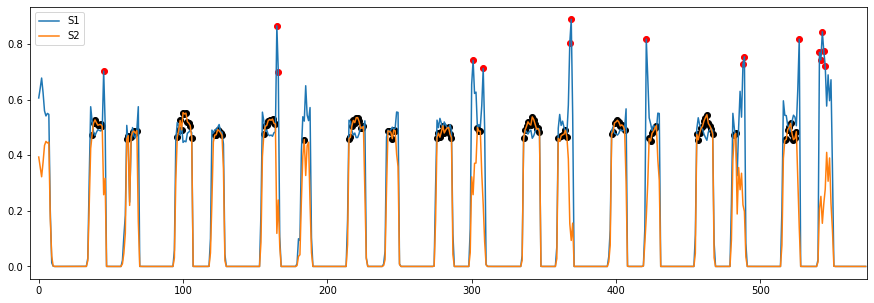

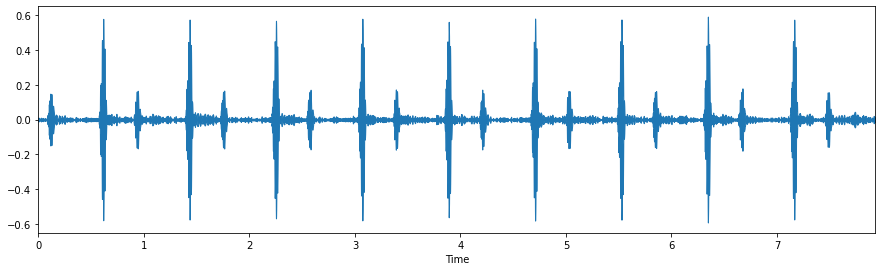

In [19]:
colSone = []
colSTwo = []
colNoise = []
for item in predictions:
    
    colSone.append(item[0])
    colSTwo.append(item[1])
    colNoise.append(item[2])
    
positionS1 = dict() 
positionS2 = dict()

for S2 in colSTwo:
    for S1 in colSone:
        if S2>0.45:
            index = colSTwo.index(S2)
            positionS2[index]=S2
            a = int(index)+10
            b = int(index)-10
            if S1>0.7:
                ind1=colSone.index(S1)
                for i in range(b,a):
                    if ind1==i:
                        continue
                    else:
                        index = colSone.index(S1) # gets the index from the element
                        positionS1[index]=S1 # adds the element as a value to the index as a key

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(colSone, label='S1')
plt.plot(colSTwo, label='S2')
#plt.plot(colNoise, label='Noise')
plt.xlim(-6, 574)
plt.scatter(positionS1.keys(), positionS1.values(), c='red')
plt.scatter(positionS2.keys(), positionS2.values(), c='black')
plt.legend()

# plot waves of S1
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.add_subplot(2,1,2)
name = '../set_a/normal__201108011112.wav'
data, sample_rate = librosa.load(name)
librosa.display.waveplot(data, sr = sample_rate)

In [17]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/negromontebs/seta/3ab1d37d6edb4506aee1163539efb7da
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad       : False
COMET INFO:     Adam_beta_1        : 0.8999999761581421
COMET INFO:     Adam_beta_2        : 0.9990000128746033
COMET INFO:     Adam_decay         : 0.0
COMET INFO:     Adam_epsilon       : 1e-07
COMET INFO:     Adam_learning_rate : 0.0010000000474974513
COMET INFO:     Optimizer          : Adam
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.58 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages          